In [1]:
# pip install basemap

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
import datetime
import random
from scipy import stats
import seaborn as sns
#=========================================
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap

In [3]:
#Read .csv file for output
aviation_data = pd.read_csv("./dataset/airline_data.csv")
#aviation_data.head()

### Get columns from ./dataset/airline_data.csv we are going to perfom calculations on

In [4]:
aviation_data = pd.read_csv("./dataset/airline_data.csv")
aviation_data.head()
flights = aviation_data.to_dict(orient='records')
filtered_flights = []
for flight in flights:
    flight_date = str(flight["month"])
    if flight_date.startswith("11") or flight_date.startswith("12"):
        filtered_flights.append(flight)
print(len(filtered_flights))
formatted_flights = []
random_flights = random.sample(filtered_flights, min(200, len(filtered_flights)))
print(f"Number of randomly selected flights: {len(random_flights)}")
for flight in random_flights:
    airline_name = flight["carrier_name"]
    arrival_airport = flight["airport"]
    airport_name = flight["airport_name"]
    month = flight["month"]
    year = flight["year"]
    airline_delay = flight["carrier_delay"]
    weather_delay = flight["weather_delay"]
    nas_delay = flight["nas_delay"]
    security_delay = flight["security_delay"]
    late_aircraft_delay = flight["late_aircraft_delay"]
    count_airline_delay = flight["carrier_ct"]
    count_weather_delay = flight["weather_ct"]
    count_nas_delay = flight["nas_ct"]
    count_security_delay = flight["security_ct"]
    count_late_aircraft_delay = flight["late_aircraft_ct"]
    # NAS is the National Aviation System
    formatted_flights.append({
        "Year": year,
        "Month": month,
        "Airline Name": airline_name,
        "Arrival Airport": arrival_airport,
        "airport_name": airport_name,
        "Delay due to Airline in Mins": airline_delay,
        "Delay due to Weather in Mins": weather_delay,
        "Delay due to NAS in Mins": nas_delay,
        "Delay due to Security in Mins": security_delay,
        "Delay due to Late Aircraft in Mins": late_aircraft_delay,
        "# of Airline Delays": count_airline_delay,
        "# of Weather Delays": count_weather_delay,
        "# of NAS Delays": count_nas_delay,
        "# of Security Delays": count_security_delay,
        "# of Late Aircraft Delays": count_late_aircraft_delay
    })

11445
Number of randomly selected flights: 200


In [5]:
#Find unique values of the "flight_date"
print(aviation_data["flight_date"].unique())

['12/2023' '11/2023' '10/2023' '9/2023' '8/2023' '7/2023' '6/2023'
 '5/2023' '4/2023' '3/2023' '2/2023' '1/2023' '12/2022' '11/2022'
 '10/2022' '9/2022' '8/2022' '7/2022' '6/2022' '5/2022' '4/2022' '3/2022'
 '2/2022' '1/2022' '12/2021' '11/2021']


In [6]:
#Find random number of given flights
for flight in random_flights[:5]:
        print(flight["flight_date"])

12/2021
11/2023
11/2023
11/2022
12/2023


In [7]:
# Create and print Data Frame
flight_data_df = pd.DataFrame(formatted_flights)

#print(flight_data_df)

In [8]:
flight_data_df.to_csv("./dataset/flights.csv", index=True) #, mode='w')

flight_data_df = pd.read_csv("./dataset/flights.csv", index_col=0)

#flight_data_df.head()

---

# U.S. Department of Transportation
## The information is presented from Federal Aviation Administration website

---

# Calculations based on Nov-Dec 2021-2023

## Import the data from .csv and the coordinates dataset and merge it with the existing dataset. 

In [9]:
#====Merging=====================================
'''"./dataset/airline_data.csv"'''
#flights_path_aa = "./dataset/flights_aa.csv"
flights_path = "./dataset/flights.csv"
airports_path = "./dataset/airports.csv"
#iata_coords_path = "iata_coords.csv"

flights_data = pd.read_csv(flights_path, low_memory=False)
airports_data = pd.read_csv(airports_path, low_memory=False)

#data_merged_df = pd.merge(airports_data, flights_data, on="Arrival Airport")

### Display the number of carriers with the lowest # of Airline Delays Nov-Dec   2021-2023

We group the rows in df by carrier and sum the number of delayed arrivals per carrier. We are only interested in the carriers
 with the smallest number of delayed arrivals. For display purposes,
 we pass the name parameter in our call to reset_index().
 data_ads_df   ---> # of smalest airline delays 

In [10]:
data_ads_df = flight_data_df #pd.read_csv("./dataset/flights.csv", index_col=0)
data_ads_df.groupby('Airline Name')['# of Airline Delays'].sum().nsmallest().reset_index(name='num_delays')
#flight_data_df.groupby('Airline Name')['# of Weather Delays'].sum().nlargest(50).reset_index(name='num_delays')

,Airline Name,num_delays
0,"Commutair Aka Champlain Enterprises, Inc.",2.26
1,GoJet Airlines LLC d/b/a United Express,5.52
2,Republic Airline,12.79
3,Hawaiian Airlines Network,16.97
4,CommuteAir LLC dba CommuteAir,17.49


### Display the number of carriers with the largest # of Airline Delays  Nov-Dec   2021-2023

We group the rows in df by carrier and sum the number of delayed arrivals per carrier. We are only interested in the carriers
 with the largest number of delayed arrivals. For display purposes,
 we pass the name parameter in our call to reset_index().      data_adl_df   ---> # of largest airline delays 

In [11]:
data_adl_df = flight_data_df #pd.read_csv("./dataset/flights.csv", index_col=0)
# nsmallest(10)   <----change the number
data_adl_df.groupby('Airline Name')['# of Airline Delays'].sum().nlargest().reset_index(name='num_delays')

,Airline Name,num_delays
0,Southwest Airlines,1488.50
1,United Air Lines Network,1055.00
2,SkyWest Airlines Inc.,380.78
3,Delta Air Lines Network,347.53
4,American Airlines Network,304.52


---

###   # of Late Aircraft Delays

In [12]:
# # Load the CSV file into a DataFrame
# df = pd.read_csv('./dataset/flights.csv')  # replace 'your_file.csv' with your actual file name

# # Display the first few rows of the DataFrame to understand its structure
# #print(df.head())

# # Assuming there is a column named 'time_minutes' that contains the time in minutes
# # Convert seconds to hours
# df['Delay due to Airline in Mins'] = (df['Delay due to Airline in Mins'] / 60).round(2)
# #Creat df for output
# out_df = pd.DataFrame(df)
# flights = out_df

In [13]:
# # Assuming you have a dataset named 'flights' with columns 'Airline Name' and 'Delay due to Weather in Mins'
# # Replace with your actual dataset and column names

# #Load your dataset
# #flights = out_df

# #Group by airline and calculate average delay
# airline_delays = flights.groupby('Airline Name')['Delay due to Airline in Mins'].mean().reset_index()

# # Sort by average delay
# airline_delays = airline_delays.sort_values(by='Delay due to Airline in Mins', ascending=False)

# # Create the bar plot
# plt.figure(figsize=(11, 6))
# plt.bar(airline_delays['Airline Name'], airline_delays['Delay due to Airline in Mins'])
# plt.xlabel('Airline Name')
# plt.ylabel('Average Delay (hours)')
# plt.title('Average Flight Delays due to Airline in Mins Nov-Dec 2021-2023')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()
# #airline_delays

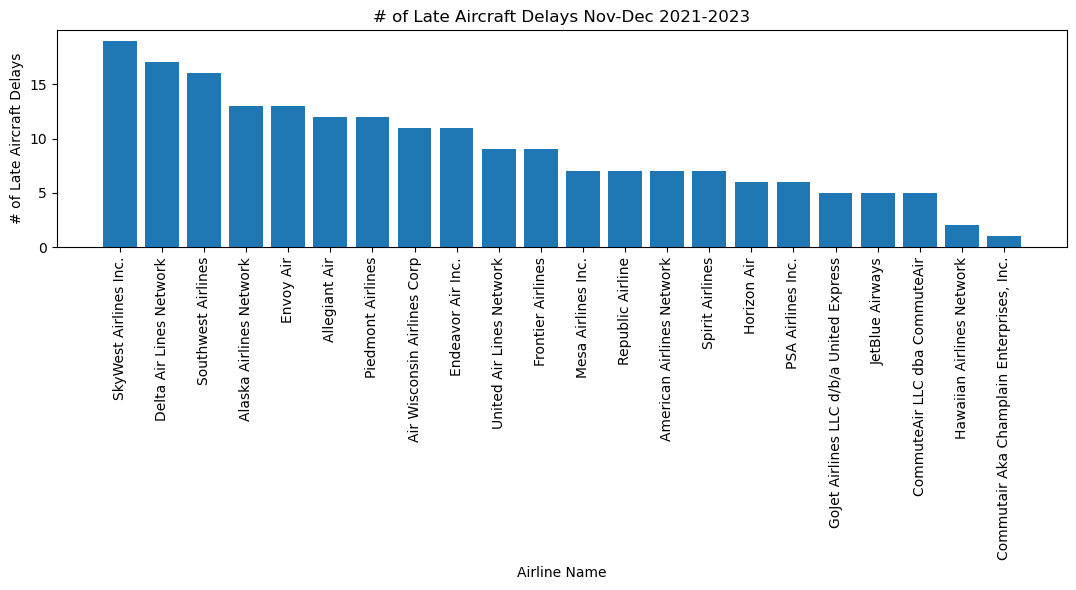

In [14]:
# Assuming you have a dataset named 'flights' with columns 'Airline Name' and 'Delay due to Weather in Mins'
# Replace with your actual dataset and column names

# Load your dataset
#flights = out_df
df = pd.read_csv('./dataset/flights.csv')
#flights = pd.DataFrame(df)
# Group by airline and calculate average delay
#airline_delays = flights.groupby('Airline Name')['Delay due to Weather in Mins'].mean().reset_index()
airline_delays = df.groupby('Airline Name')['# of Late Aircraft Delays'].count().reset_index()

# Sort by average delay
airline_delays = airline_delays.sort_values(by='# of Late Aircraft Delays', ascending=False)

# Create the bar plot
plt.figure(figsize=(11, 6))
plt.bar(airline_delays['Airline Name'], airline_delays['# of Late Aircraft Delays'])
plt.xlabel('Airline Name')
plt.ylabel('# of Late Aircraft Delays')
plt.title('# of Late Aircraft Delays Nov-Dec 2021-2023')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
#airline_delays

### Basic statistical description of airlines
### *Calculate    min  max  count	 mean   on the # of Airline Delays  Nov-Dec  2021-2023*

In [15]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean().round()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = flight_data_df['# of Airline Delays'].groupby(flight_data_df['Airline Name']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
Airline Name,,,,
"Commutair Aka Champlain Enterprises, Inc.",2.26,2.26,1.0,2.0
Hawaiian Airlines Network,4.94,12.03,2.0,8.0
GoJet Airlines LLC d/b/a United Express,0.00,3.86,5.0,1.0
CommuteAir LLC dba CommuteAir,1.00,6.41,5.0,3.0
JetBlue Airways,1.00,26.89,5.0,8.0
PSA Airlines Inc.,2.14,10.86,6.0,6.0
Horizon Air,0.00,28.95,6.0,7.0
Republic Airline,0.00,5.28,7.0,2.0
American Airlines Network,2.52,220.35,7.0,44.0
